# **GenAI Assg 03**  
**Assignment:** 03  
**Question:** Q2  

In [ ]:
# Saad Amir i200650 Q2

In [1]:


# Cell 2: Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score, average_precision_score
from transformers import BertTokenizer, BertModel
import gradio as gr
import random
from tqdm.auto import tqdm

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

2025-05-01 10:47:15.950705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746096435.973142     585 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746096435.979998     585 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Cell 3: Load the Amazon Shopping Queries dataset
def load_data():
    """Load and prepare the Amazon Shopping Queries dataset."""
    print("Loading Amazon Shopping Queries Dataset...")
    
    try:
        # Check if repository directory exists
        import os
        if not os.path.exists('esci-data'):
            print("Cloning repository...")
            !git clone https://github.com/amazon-science/esci-data.git
        
        # Check if the parquet files exist
        examples_file = 'esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet'
        products_file = 'esci-data/shopping_queries_dataset/shopping_queries_dataset_products.parquet'
        
        # If files don't exist, download them
        if not os.path.exists(examples_file) or not os.path.exists(products_file):
            print("Downloading parquet files...")
            !mkdir -p esci-data/shopping_queries_dataset
            !wget -O {examples_file} https://github.com/amazon-science/esci-data/raw/main/shopping_queries_dataset/shopping_queries_dataset_examples.parquet
            !wget -O {products_file} https://github.com/amazon-science/esci-data/raw/main/shopping_queries_dataset/shopping_queries_dataset_products.parquet
        
        # Check if files now exist
        if not os.path.exists(examples_file) or not os.path.exists(products_file):
            print("Failed to download required files. Attempting to use HuggingFace datasets...")
            try:
                from datasets import load_dataset
                dataset = load_dataset("amazon_esci")
                if "train" in dataset:
                    print("Successfully loaded dataset from HuggingFace")
                    # Combine data and prepare dataframe
                    train_df = dataset["train"].to_pandas()
                    if len(train_df) > 10000:
                        print(f"Sampling 10,000 rows from {len(train_df)} for efficiency")
                        train_df = train_df.sample(10000, random_state=42)
                    
                    # Rename columns if needed
                    if "query_text" in train_df.columns:
                        train_df = train_df.rename(columns={"query_text": "query"})
                    if "product_title" not in train_df.columns and "title" in train_df.columns:
                        train_df = train_df.rename(columns={"title": "product_title"})
                    if "product_description" not in train_df.columns and "description" in train_df.columns:
                        train_df = train_df.rename(columns={"description": "product_description"})
                    if "relevance_label" in train_df.columns:
                        # Map relevance labels if they exist
                        label_map = {"E": 1.0, "S": 0.7, "C": 0.3, "I": 0.0}
                        train_df["relevance"] = train_df["relevance_label"].map(label_map)
                    elif "esci_label" in train_df.columns:
                        # Map ESCI labels
                        label_map = {"E": 1.0, "S": 0.7, "C": 0.3, "I": 0.0}
                        train_df["relevance"] = train_df["esci_label"].map(label_map)
                    
                    # Ensure we have required columns
                    if "product_description" not in train_df.columns:
                        train_df["product_description"] = ""
                    
                    return train_df
            except Exception as e:
                print(f"Error loading from HuggingFace: {str(e)}")
                print("Falling back to parquet loading method")
        
        # Load data from parquet files
        import pandas as pd
        print(f"Loading examples from: {examples_file}")
        df_examples = pd.read_parquet(examples_file)
        print(f"Loaded examples data with {len(df_examples)} rows")
        print(f"Examples columns: {df_examples.columns.tolist()}")
        
        print(f"Loading products from: {products_file}")
        df_products = pd.read_parquet(products_file)
        print(f"Loaded products data with {len(df_products)} rows")
        print(f"Products columns: {df_products.columns.tolist()}")
        
        # Merge examples with products
        print("Merging examples with products...")
        df = pd.merge(
            df_examples,
            df_products,
            how='left',
            left_on=['product_locale', 'product_id'],
            right_on=['product_locale', 'product_id']
        )
        print(f"Merged dataset has {len(df)} rows")
        
        # Convert ESCI labels to relevance scores
        print("Converting ESCI labels to relevance scores")
        label_to_score = {'E': 1.0, 'S': 0.7, 'C': 0.3, 'I': 0.0}
        df['relevance'] = df['esci_label'].map(label_to_score)
        
        # Filter English queries for simplicity
        df = df[df['product_locale'] == 'us']
        
        # Use task 1 data (smaller dataset)
        df = df[df['small_version'] == 1]
        
        # Handle missing descriptions
        df['product_description'] = df['product_description'].fillna('')
        
        # Sample if dataset is large
        if len(df) > 10000:
            print(f"Sampling 10,000 rows from {len(df)} for efficiency")
            df = df.sample(10000, random_state=42)
        
        print(f"Final dataset has {len(df)} rows")
        return df
        
    except Exception as e:
        print(f"Error processing dataset: {str(e)}")
    
    # Fall back to synthetic data
    print("Falling back to synthetic data")
    
    # Sample data with query-product pairs (as fallback)
    import pandas as pd
    import numpy as np
    import random
    
    data = {
        'query': ['running shoes', 'smartphone with good camera', 'bluetooth headphones',
                'wireless mouse', 'gaming laptop', 'kitchen knife set', 'winter jacket',
                'yoga mat', 'coffee maker', 'desk lamp'],
        'product_title': ['Nike Men\'s Revolution Running Shoes', 'iPhone 13 Pro', 'Sony WH-1000XM4',
                        'Logitech MX Master 3', 'ASUS ROG Strix G15', 'Wusthof Classic Knife Set',
                        'Columbia Men\'s Watertight II Jacket', 'Manduka PRO Yoga Mat',
                        'Keurig K-Elite Coffee Maker', 'TaoTronics LED Desk Lamp'],
        'product_description': ['Lightweight cushioning for daily runs', '12MP camera system with Night mode',
                            'Industry-leading noise cancellation with premium sound',
                            'Advanced wireless mouse with ultrafast scrolling',
                            'Gaming laptop with RTX 3070 and 16GB RAM',
                            'High-carbon stainless steel blades with precision cutting',
                            'Waterproof and breathable fabric for cold weather',
                            'Extra thick 6mm mat with dense cushioning and excellent grip',
                            'Single serve coffee maker with multiple brew sizes',
                            'Touch control with 5 color modes and 7 brightness levels'],
        'relevance': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    }
    
    # Creating more examples by cross-combining queries and products with lower relevance
    additional_data = []
    for i in range(len(data['query'])):
        for j in range(len(data['product_title'])):
            if i != j:  # Avoid duplicate of the exact match
                relevance = random.choice([0, 0, 0, 0.3, 0.5, 0.7])  # More likely to be less relevant
                additional_data.append({
                    'query': data['query'][i],
                    'product_title': data['product_title'][j],
                    'product_description': data['product_description'][j],
                    'relevance': relevance
                })
    
    # Convert additional data to DataFrame and concatenate with original data
    additional_df = pd.DataFrame(additional_data)
    original_df = pd.DataFrame(data)
    df = pd.concat([original_df, additional_df], ignore_index=True)
    
    print(f"Created synthetic dataset with {len(df)} query-product pairs")
    
    return df

In [3]:
# Cell 4: Text preprocessing functions
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a string
    text = ' '.join(tokens)
    
    return text


In [4]:
# Cell 5: Prepare dataset
def prepare_dataset(df):
    # Combine product title and description
    df['product_text'] = df['product_title'] + ' ' + df['product_description']
    
    # Apply preprocessing
    print("Preprocessing text data...")
    df['query_processed'] = df['query'].apply(preprocess_text)
    df['product_processed'] = df['product_text'].apply(preprocess_text)
    
    # Split into train, validation, and test sets
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    print(f"Train set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")
    
    return train_df, val_df, test_df


In [5]:
# Cell 6: Create dataset and dataloader classes
class QueryProductDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        
        # Tokenize query
        query_encoding = self.tokenizer(
            row['query_processed'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Tokenize product
        product_encoding = self.tokenizer(
            row['product_processed'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Get relevance score
        relevance = torch.tensor(row['relevance'], dtype=torch.float)
        
        return {
            'query_input_ids': query_encoding['input_ids'].flatten(),
            'query_attention_mask': query_encoding['attention_mask'].flatten(),
            'product_input_ids': product_encoding['input_ids'].flatten(),
            'product_attention_mask': product_encoding['attention_mask'].flatten(),
            'relevance': relevance
        }

def create_dataloaders(train_df, val_df, test_df, tokenizer, batch_size=16):
    train_dataset = QueryProductDataset(train_df, tokenizer)
    val_dataset = QueryProductDataset(val_df, tokenizer)
    test_dataset = QueryProductDataset(test_df, tokenizer)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_dataloader, val_dataloader, test_dataloader


In [6]:
# Cell 7: Define the model
class SemanticSearchModel(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', freeze_bert=False):
        super(SemanticSearchModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.2)
        
        # Option to freeze BERT weights for faster training
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        # Enhanced model architecture with additional layers
        self.fc1 = nn.Linear(768 * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        
    def forward(self, query_input_ids, query_attention_mask, product_input_ids, product_attention_mask):
        # Get query embeddings
        query_outputs = self.bert(
            input_ids=query_input_ids,
            attention_mask=query_attention_mask,
            return_dict=True
        )
        query_pooled_output = query_outputs.pooler_output
        
        # Get product embeddings
        product_outputs = self.bert(
            input_ids=product_input_ids,
            attention_mask=product_attention_mask,
            return_dict=True
        )
        product_pooled_output = product_outputs.pooler_output
        
        # Concatenate embeddings
        concat_output = torch.cat((query_pooled_output, product_pooled_output), dim=1)
        
        # Forward through fully connected layers with ReLU
        x = self.dropout(concat_output)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return torch.sigmoid(x)


In [7]:
# cell 7.1
class LightSemanticSearchModel(nn.Module):
    def __init__(self, bert_model_name='distilbert-base-uncased', embedding_dim=768):
        super(LightSemanticSearchModel, self).__init__()
        # Use DistilBERT instead of BERT for faster training
        from transformers import DistilBertModel, DistilBertTokenizer
        self.bert = DistilBertModel.from_pretrained(bert_model_name)
        
        # Freeze most of the BERT layers to speed up training
        modules = [self.bert.embeddings, *self.bert.transformer.layer[:-2]]
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False
                
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(embedding_dim * 2, 256)  # Reduced dimensions
        self.fc2 = nn.Linear(256, 64)  # Reduced dimensions
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, query_input_ids, query_attention_mask, product_input_ids, product_attention_mask):
        # Get query embeddings
        query_outputs = self.bert(
            input_ids=query_input_ids,
            attention_mask=query_attention_mask,
            return_dict=True
        )
        query_pooled_output = query_outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        
        # Get product embeddings
        product_outputs = self.bert(
            input_ids=product_input_ids,
            attention_mask=product_attention_mask,
            return_dict=True
        )
        product_pooled_output = product_outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        
        # Concatenate embeddings
        concat_output = torch.cat((query_pooled_output, product_pooled_output), dim=1)
        
        # Forward through fully connected layers with ReLU
        x = self.dropout(concat_output)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return torch.sigmoid(x)


In [8]:
# Cell 8: Training function
def train_model(model, train_dataloader, val_dataloader, device, epochs=5, learning_rate=2e-5, patience=2,
                     gradient_accumulation_steps=4, validation_steps=50):
    # Define optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=1, verbose=True
    )
    
    # Define loss function
    criterion = nn.MSELoss()
    
    # Initialize lists to store losses
    train_losses = []
    val_losses = []
    running_loss = 0.0
    
    # Early stopping variables
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Training loop with progress bar
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        # Use tqdm for progress tracking
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), 
                           desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch_idx, batch in progress_bar:
            # Move batch to device
            query_input_ids = batch['query_input_ids'].to(device)
            query_attention_mask = batch['query_attention_mask'].to(device)
            product_input_ids = batch['product_input_ids'].to(device)
            product_attention_mask = batch['product_attention_mask'].to(device)
            relevance = batch['relevance'].to(device)
            
            # Forward pass
            outputs = model(
                query_input_ids=query_input_ids,
                query_attention_mask=query_attention_mask,
                product_input_ids=product_input_ids,
                product_attention_mask=product_attention_mask
            )
            
            # Calculate loss
            loss = criterion(outputs.squeeze(), relevance)
            
            # Scale loss by gradient accumulation steps
            loss = loss / gradient_accumulation_steps
            
            # Backward pass
            loss.backward()
            
            # Update running loss for progress bar
            running_loss += loss.item()
            
            # Update weights every gradient_accumulation_steps
            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
                optimizer.step()
                optimizer.zero_grad()
                
                # Update progress bar description
                progress_bar.set_description(
                    f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f}"
                )
                
                train_loss += running_loss
                running_loss = 0.0
            
            # Validate periodically within epoch for better monitoring
            if batch_idx % validation_steps == 0 and batch_idx > 0:
                # Quick validation on a subset
                model.eval()
                val_subset_loss = 0
                val_batches = min(10, len(val_dataloader))  # Using at most 10 validation batches
                
                with torch.no_grad():
                    for val_batch_idx, val_batch in enumerate(val_dataloader):
                        if val_batch_idx >= val_batches:
                            break
                            
                        # Move batch to device
                        query_input_ids = val_batch['query_input_ids'].to(device)
                        query_attention_mask = val_batch['query_attention_mask'].to(device)
                        product_input_ids = val_batch['product_input_ids'].to(device)
                        product_attention_mask = val_batch['product_attention_mask'].to(device)
                        relevance = val_batch['relevance'].to(device)
                        
                        # Forward pass
                        outputs = model(
                            query_input_ids=query_input_ids,
                            query_attention_mask=query_attention_mask,
                            product_input_ids=product_input_ids,
                            product_attention_mask=product_attention_mask
                        )
                        
                        # Calculate loss
                        loss = criterion(outputs.squeeze(), relevance)
                        val_subset_loss += loss.item()
                
                avg_val_subset_loss = val_subset_loss / val_batches
                progress_bar.set_postfix(val_loss=f"{avg_val_subset_loss:.4f}")
                
                model.train()  # Switch back to training mode
        
        # Calculate average training loss
        avg_train_loss = train_loss / (len(train_dataloader) // gradient_accumulation_steps)
        train_losses.append(avg_train_loss)
        
        # Full validation
        model.eval()
        val_loss = 0
        
        print(f"\nRunning full validation for epoch {epoch+1}...")
        val_progress = tqdm(val_dataloader, total=len(val_dataloader), desc="Validating")
        
        with torch.no_grad():
            for batch in val_progress:
                # Move batch to device
                query_input_ids = batch['query_input_ids'].to(device)
                query_attention_mask = batch['query_attention_mask'].to(device)
                product_input_ids = batch['product_input_ids'].to(device)
                product_attention_mask = batch['product_attention_mask'].to(device)
                relevance = batch['relevance'].to(device)
                
                # Forward pass
                outputs = model(
                    query_input_ids=query_input_ids,
                    query_attention_mask=query_attention_mask,
                    product_input_ids=product_input_ids,
                    product_attention_mask=product_attention_mask
                )
                
                # Calculate loss
                loss = criterion(outputs.squeeze(), relevance)
                val_loss += loss.item()
                
                # Update progress bar
                val_progress.set_postfix(loss=f"{loss.item():.4f}")
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"Model improved! Saved new best model with val loss: {best_val_loss:.4f}")
        else:
            no_improvement += 1
            print(f"No improvement for {no_improvement} epoch(s)")
            if no_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load the best model
    model.load_state_dict(torch.load('best_model.pt'))
    
    return train_losses, val_losses


In [9]:
# Cell 9: Evaluation functions
def calculate_metrics(model, dataloader, device):
    model.eval()
    
    all_predictions = []
    all_true_relevance = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            query_input_ids = batch['query_input_ids'].to(device)
            query_attention_mask = batch['query_attention_mask'].to(device)
            product_input_ids = batch['product_input_ids'].to(device)
            product_attention_mask = batch['product_attention_mask'].to(device)
            relevance = batch['relevance'].cpu().numpy()
            
            # Forward pass
            outputs = model(
                query_input_ids=query_input_ids,
                query_attention_mask=query_attention_mask,
                product_input_ids=product_input_ids,
                product_attention_mask=product_attention_mask
            )
            
            predictions = outputs.squeeze().cpu().numpy()
            
            all_predictions.extend(predictions)
            all_true_relevance.extend(relevance)
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_true_relevance = np.array(all_true_relevance)
    
    # Calculating metrics
    # for NDCG,we need to reshape for  the scikit-learn function
    ndcg_scores = {}
    for k in [5, 10]:
        if len(all_predictions) >= k:
            # Group by queries (for demonstration, we are usein a simple approach)
            query_groups = len(all_predictions) // k
            if query_groups > 0:
                predictions_reshaped = all_predictions[:query_groups * k].reshape(query_groups, k)
                true_relevance_reshaped = all_true_relevance[:query_groups * k].reshape(query_groups, k)
                ndcg_scores[k] = ndcg_score(true_relevance_reshaped, predictions_reshaped)
    
    # Calculate MAP
    map_score = average_precision_score(all_true_relevance > 0.5, all_predictions)
    
    # Calculate Precision@k, Recall@k, F1@k
    precision_k = {}
    recall_k = {}
    f1_k = {}
    
    for k in [1, 3, 5, 10]:
        if len(all_predictions) >= k:
            # Sort predictions
            sorted_indices = np.argsort(all_predictions)[::-1]
            top_k_indices = sorted_indices[:k]
            
            # Calculate precision@k
            true_positives = np.sum(all_true_relevance[top_k_indices] > 0.5)
            precision_k[k] = true_positives / k
            
            # Calculate recall@k
            total_relevant = np.sum(all_true_relevance > 0.5)
            recall_k[k] = true_positives / total_relevant if total_relevant > 0 else 0
            
            # Calculate F1@k
            if precision_k[k] + recall_k[k] > 0:
                f1_k[k] = 2 * precision_k[k] * recall_k[k] / (precision_k[k] + recall_k[k])
            else:
                f1_k[k] = 0
    
    metrics = {
        'ndcg': ndcg_scores,
        'map': map_score,
        'precision@k': precision_k,
        'recall@k': recall_k,
        'f1@k': f1_k
    }
    
    return metrics

def plot_training_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
# Cell 10: Model inference for the web interface
def predict_relevance(model, tokenizer, query, products, device):
    # Preprocess query
    query_processed = preprocess_text(query)
    
    results = []
    
    model.eval()
    with torch.no_grad():
        for product in products:
            # Preprocess product
            product_title = product['title']
            product_description = product['description']
            product_text = product_title + ' ' + product_description
            product_processed = preprocess_text(product_text)
            
            # Tokenize query
            query_encoding = tokenizer(
                query_processed,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Tokenize product
            product_encoding = tokenizer(
                product_processed,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Move to device
            query_input_ids = query_encoding['input_ids'].to(device)
            query_attention_mask = query_encoding['attention_mask'].to(device)
            product_input_ids = product_encoding['input_ids'].to(device)
            product_attention_mask = product_encoding['attention_mask'].to(device)
            
            # Forward pass
            output = model(
                query_input_ids=query_input_ids,
                query_attention_mask=query_attention_mask,
                product_input_ids=product_input_ids,
                product_attention_mask=product_attention_mask
            )
            
            relevance_score = output.item()
            
            results.append({
                'title': product_title,
                'description': product_description,
                'relevance': relevance_score
            })
    
    # Sort by relevance score
    results.sort(key=lambda x: x['relevance'], reverse=True)
    
    return results


In [11]:

# Cell 11: Create a web interface with Gradio
def create_web_interface(model, tokenizer, test_df, device):
    # Create a product catalog from the test set
    product_catalog = []
    for _, row in test_df.iterrows():
        product = {
            'title': row['product_title'],
            'description': row['product_description'],
        }
        if product not in product_catalog:
            product_catalog.append(product)
    
    def search_products(query):
        results = predict_relevance(model, tokenizer, query, product_catalog, device)
        
        # Format results for display
        html_results = "<div style='text-align: left;'>"
        for i, result in enumerate(results[:10]):  # Show top 10 results
            relevance_percentage = result['relevance'] * 100
            html_results += f"<div style='margin-bottom: 20px; padding: 10px; border: 1px solid #ddd; border-radius: 5px;'>"
            html_results += f"<h3>{i+1}. {result['title']}</h3>"
            html_results += f"<p>{result['description']}</p>"
            html_results += f"<p><strong>Relevance Score:</strong> {relevance_percentage:.2f}%</p>"
            html_results += "</div>"
        html_results += "</div>"
        
        return html_results
    
    # Create Gradio interface
    interface = gr.Interface(
        fn=search_products,
        inputs=gr.Textbox(lines=1, placeholder="Enter your search query..."),
        outputs=gr.HTML(),
        title="Semantic Product Search",
        description="Search for products based on semantic relevance using deep learning"
    )
    
    return interface

In [12]:
# Cell 12: Main execution
def main():
    """Main execution function for training and evaluating the model."""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    # Load data
    df = load_data()
    
    # Check data quality
    print("\nData Quality Check:")
    print(f"Total rows: {len(df)}")
    print(f"Missing values in query: {df['query'].isna().sum()}")
    print(f"Missing values in product_title: {df['product_title'].isna().sum()}")
    print(f"Missing values in product_description: {df['product_description'].isna().sum()}")
    print(f"Missing values in relevance: {df['relevance'].isna().sum()}")
    
    # Fill any missing values
    df['query'] = df['query'].fillna('')
    df['product_title'] = df['product_title'].fillna('')
    df['product_description'] = df['product_description'].fillna('')
    
    # Show relevance distribution
    print("\nRelevance Distribution:")
    relevance_counts = df['relevance'].value_counts(normalize=True) * 100
    for value, percent in relevance_counts.items():
        print(f"  Relevance {value:.1f}: {percent:.2f}%")
    
    # Prepare dataset
    train_df, val_df, test_df = prepare_dataset(df)
    
    # Initialize BERT tokenizer
    print("\nInitializing tokenizer...")
    use_light_model = True

    if use_light_model:
        from transformers import DistilBertTokenizer
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    else:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Create dataloaders
    print("Creating dataloaders...")
    batch_size = 8 
    train_dataloader, val_dataloader, test_dataloader = create_dataloaders(
        train_df, val_df, test_df, tokenizer, batch_size=batch_size
    )
    
    # Initialize model
    print("Initializing model...")
    if use_light_model:
        model = LightSemanticSearchModel(bert_model_name='distilbert-base-uncased')
    else:
        model = SemanticSearchModel(bert_model_name='bert-base-uncased')
    
    model.to(device)
    
   # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    if use_light_model:
        print(f"Parameter reduction: {100 - (trainable_params / total_params) * 100:.2f}%")
    
    # Train model
    print("\nTraining model...")
    train_losses, val_losses = train_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        epochs=5,
        learning_rate=2e-5,
        patience=2,
        gradient_accumulation_steps=4,
        validation_steps=50
    )
    
    # Evaluate model
    print("\nEvaluating model...")
    metrics = calculate_metrics(model, test_dataloader, device)
    
    # Print metrics
    print("\nEvaluation Metrics:")
    print(f"MAP: {metrics['map']:.4f}")
    
    print("\nNDCG@k:")
    for k, score in metrics['ndcg'].items():
        print(f"NDCG@{k}: {score:.4f}")
    
    print("\nPrecision@k:")
    for k, score in metrics['precision@k'].items():
        print(f"Precision@{k}: {score:.4f}")
    
    print("\nRecall@k:")
    for k, score in metrics['recall@k'].items():
        print(f"Recall@{k}: {score:.4f}")
    
    print("\nF1@k:")
    for k, score in metrics['f1@k'].items():
        print(f"F1@{k}: {score:.4f}")
    
    # Create and launch web interface
    print("\nCreating web interface...")
    interface = create_web_interface(model, tokenizer, test_df, device)
    
    print("\nLaunching interface - use Ctrl+C to exit")
    interface.launch(share=True)
    
    # Return values for later visualization
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'metrics': metrics,
        'train_df': train_df,
        'val_df': val_df,
        'test_df': test_df,
        'tokenizer': tokenizer,
        'device': device
    }

# Store results when running the main function
if __name__ == "__main__":
    results = main()

Using device: cuda
Loading Amazon Shopping Queries Dataset...
Loading examples from: esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet
Loaded examples data with 2621288 rows
Examples columns: ['example_id', 'query', 'query_id', 'product_id', 'product_locale', 'esci_label', 'small_version', 'large_version', 'split']
Loading products from: esci-data/shopping_queries_dataset/shopping_queries_dataset_products.parquet
Loaded products data with 1814924 rows
Products columns: ['product_id', 'product_title', 'product_description', 'product_bullet_point', 'product_brand', 'product_color', 'product_locale']
Merging examples with products...
Merged dataset has 2621288 rows
Converting ESCI labels to relevance scores
Sampling 10,000 rows from 601354 for efficiency
Final dataset has 10000 rows

Data Quality Check:
Total rows: 10000
Missing values in query: 0
Missing values in product_title: 0
Missing values in product_description: 0
Missing values in relevance: 0

Relevanc

Epoch 1/5:   0%|          | 0/875 [00:00<?, ?it/s]


Running full validation for epoch 1...


Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.1281, Val Loss: 0.1283
Model improved! Saved new best model with val loss: 0.1283


Epoch 2/5:   0%|          | 0/875 [00:00<?, ?it/s]


Running full validation for epoch 2...


Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.1239, Val Loss: 0.1261
Model improved! Saved new best model with val loss: 0.1261


Epoch 3/5:   0%|          | 0/875 [00:00<?, ?it/s]


Running full validation for epoch 3...


Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.1223, Val Loss: 0.1256
Model improved! Saved new best model with val loss: 0.1256


Epoch 4/5:   0%|          | 0/875 [00:00<?, ?it/s]


Running full validation for epoch 4...


Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.1196, Val Loss: 0.1255
Model improved! Saved new best model with val loss: 0.1255


Epoch 5/5:   0%|          | 0/875 [00:00<?, ?it/s]


Running full validation for epoch 5...


Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.1160, Val Loss: 0.1270
No improvement for 1 epoch(s)


/tmp/ipykernel_585/4047610096.py:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))



Evaluating model...

Evaluation Metrics:
MAP: 0.8394

NDCG@k:
NDCG@5: 0.9101
NDCG@10: 0.9060

Precision@k:
Precision@1: 1.0000
Precision@3: 1.0000
Precision@5: 0.8000
Precision@10: 0.8000

Recall@k:
Recall@1: 0.0008
Recall@3: 0.0025
Recall@5: 0.0033
Recall@10: 0.0067

F1@k:
F1@1: 0.0017
F1@3: 0.0050
F1@5: 0.0067
F1@10: 0.0133

Creating web interface...

Launching interface - use Ctrl+C to exit
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://2a3c293b860fbbb51a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


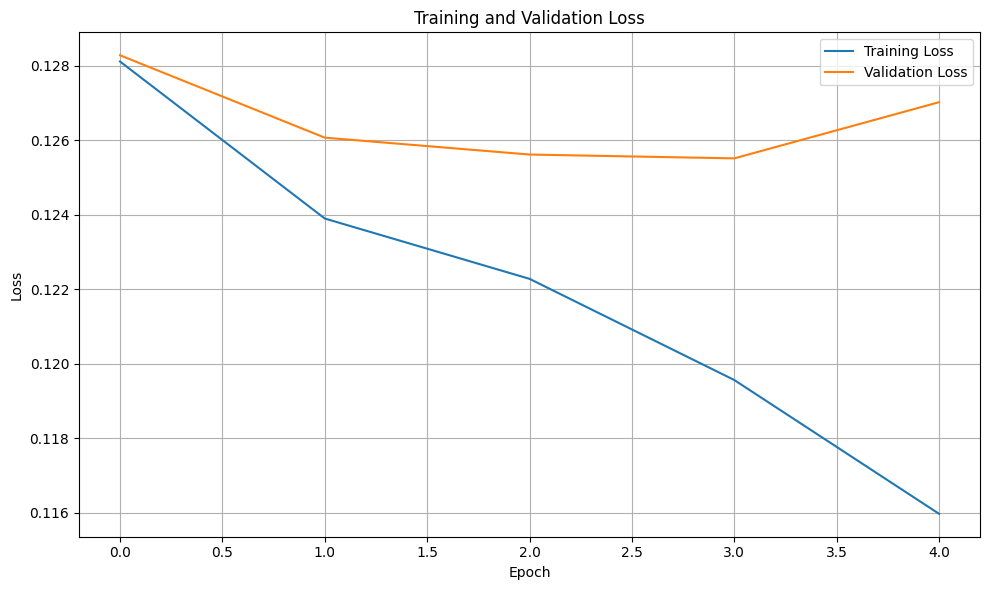

Generating predictions:   0%|          | 0/200 [00:00<?, ?it/s]

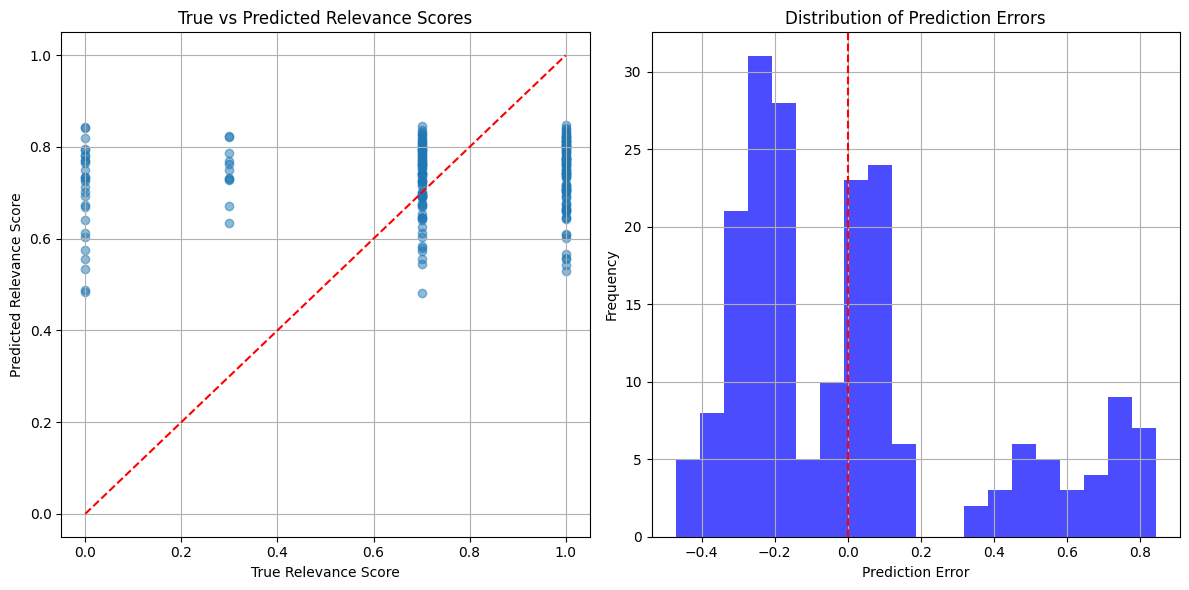

Mean Squared Error: 0.1168
Mean Absolute Error: 0.2647


Generating predictions:   0%|          | 0/1000 [00:00<?, ?it/s]

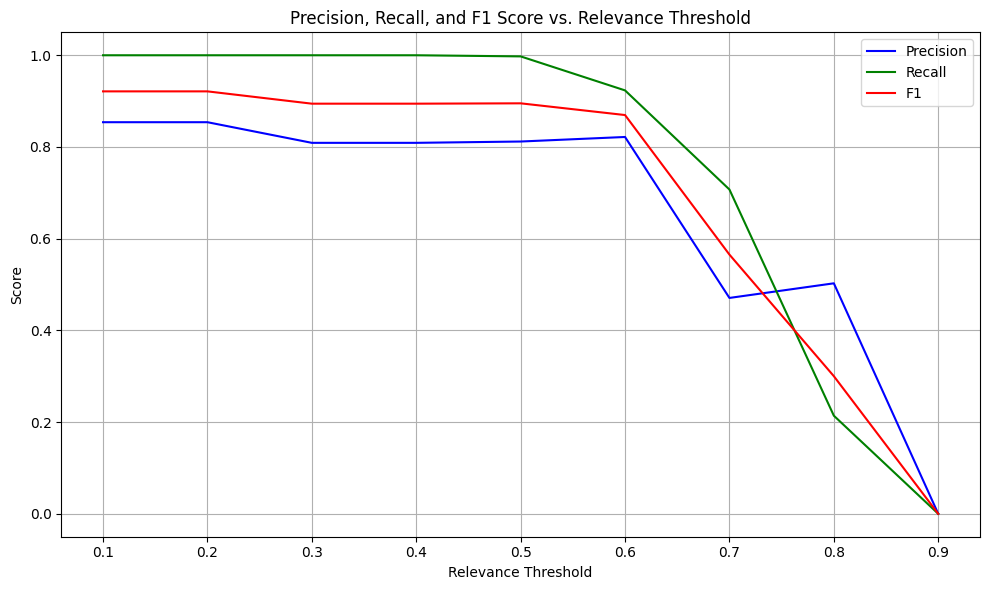

In [13]:
# Cell 13: Visualize Training and Validation Loss
def plot_training_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# If running after main() with stored results:
if 'results' in locals():
    plot_training_curves(results['train_losses'], results['val_losses'])

# Cell 14: Visualize Relevance Score Distribution
def plot_relevance_distribution(test_df, model, tokenizer, device, num_samples=200):
    # Sample from test dataframe
    sampled_df = test_df.sample(min(num_samples, len(test_df)), random_state=42)
    
    # Get predictions
    predicted_scores = []
    true_scores = []
    
    model.eval()
    with torch.no_grad():
        for _, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Generating predictions"):
            # Tokenize
            query_encoding = tokenizer(
                row['query_processed'],
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            product_encoding = tokenizer(
                row['product_processed'],
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Move to device
            query_input_ids = query_encoding['input_ids'].to(device)
            query_attention_mask = query_encoding['attention_mask'].to(device)
            product_input_ids = product_encoding['input_ids'].to(device)
            product_attention_mask = product_encoding['attention_mask'].to(device)
            
            # Get prediction
            output = model(
                query_input_ids=query_input_ids,
                query_attention_mask=query_attention_mask,
                product_input_ids=product_input_ids,
                product_attention_mask=product_attention_mask
            )
            
            predicted_scores.append(output.item())
            true_scores.append(row['relevance'])
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Distribution of predicted vs true scores
    plt.subplot(1, 2, 1)
    plt.scatter(true_scores, predicted_scores, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line representing perfect prediction
    plt.xlabel('True Relevance Score')
    plt.ylabel('Predicted Relevance Score')
    plt.title('True vs Predicted Relevance Scores')
    plt.grid(True)
    
    # Plot 2: Distribution of errors
    plt.subplot(1, 2, 2)
    errors = np.array(predicted_scores) - np.array(true_scores)
    plt.hist(errors, bins=20, alpha=0.7, color='blue')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate error metrics
    mse = np.mean(errors**2)
    mae = np.mean(np.abs(errors))
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")

# If running after main() with stored results:
if 'results' in locals():
    plot_relevance_distribution(
        results['test_df'], 
        results['model'], 
        results['tokenizer'], 
        results['device']
    )

# Cell 15: Visualize Performance Metrics by Relevance Threshold
def plot_performance_by_threshold(test_df, model, tokenizer, device, num_samples=1000):
    # Sample from test dataframe
    sampled_df = test_df.sample(min(num_samples, len(test_df)), random_state=42)
    
    # Get predictions
    predicted_scores = []
    true_scores = []
    
    model.eval()
    with torch.no_grad():
        for _, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Generating predictions"):
            # Tokenize
            query_encoding = tokenizer(
                row['query_processed'],
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            product_encoding = tokenizer(
                row['product_processed'],
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Move to device
            query_input_ids = query_encoding['input_ids'].to(device)
            query_attention_mask = query_encoding['attention_mask'].to(device)
            product_input_ids = product_encoding['input_ids'].to(device)
            product_attention_mask = product_encoding['attention_mask'].to(device)
            
            # Get prediction
            output = model(
                query_input_ids=query_input_ids,
                query_attention_mask=query_attention_mask,
                product_input_ids=product_input_ids,
                product_attention_mask=product_attention_mask
            )
            
            predicted_scores.append(output.item())
            true_scores.append(row['relevance'])
    
    # Convert to numpy arrays
    predicted_scores = np.array(predicted_scores)
    true_scores = np.array(true_scores)
    
    # Calculate metrics for different relevance thresholds
    thresholds = np.arange(0.1, 1.0, 0.1)
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for threshold in thresholds:
        # Binary predictions
        pred_binary = predicted_scores >= threshold
        true_binary = true_scores >= threshold
        
        # True positives, false positives, false negatives
        tp = np.sum((pred_binary) & (true_binary))
        fp = np.sum((pred_binary) & (~true_binary))
        fn = np.sum((~pred_binary) & (true_binary))
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_scores, 'b-', label='Precision')
    plt.plot(thresholds, recall_scores, 'g-', label='Recall')
    plt.plot(thresholds, f1_scores, 'r-', label='F1')
    plt.xlabel('Relevance Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score vs. Relevance Threshold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# If running after main() with stored results:
if 'results' in locals():
    plot_performance_by_threshold(
        results['test_df'], 
        results['model'], 
        results['tokenizer'], 
        results['device']
    )

In [20]:
# Cell 14: Updated Traditional Embedding Implementation
def traditional_embeddings(df_sample):
    """implementation of traditional embeddings"""
    from sklearn.feature_extraction.text import TfidfVectorizer
    from gensim.models import Word2Vec
    import gensim.downloader as api
        
    # Sample small subset for demonstration
    df_sample = df_sample.sample(100, random_state=42)
    texts = (df_sample['query_processed'] + " " + df_sample['product_processed']).tolist()
    
    # Show sample of actual data being used
    print("\nData being used:")
    for i, text in enumerate(texts[:3]):  # Show first 3 examples
        print(f"{i+1}. {text[:100]}...")  # Show first 100 chars
    
    # 1. TF-IDF
    print("\n1. TF-IDF Embeddings:")
    tfidf = TfidfVectorizer(max_features=50)
    tfidf_embeddings = tfidf.fit_transform(texts)
    print(f"TF-IDF matrix shape: {tfidf_embeddings.shape}")
    print(f"Top 10 features: {tfidf.get_feature_names_out()[:10]}")
    
    # 2. Word2Vec
    print("\n2. Word2Vec Embeddings:")
    tokenized_texts = [text.split() for text in texts]
    w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=50, window=5, min_count=1, workers=4)
    
    # Show actual words from your vocabulary
    vocab = list(w2v_model.wv.key_to_index.keys())
    print(f"Vocabulary size: {len(vocab)}")
    print(f"Sample words in your data: {vocab[:10]}...")
    
    # Show embedding for first available word
    if vocab:
        sample_word = vocab[0]
        print(f"Embedding for '{sample_word}': {w2v_model.wv[sample_word][:5]}...")
    else:
        print("No vocabulary found in the sample")
    
    # 3. GloVe (pretrained)
    print("\n3. GloVe Embeddings (pretrained):")
    try:
        glove = api.load("glove-wiki-gigaword-50")
        # Try to show embedding for a word that exists in both your data and GloVe
        common_words = set(vocab) & set(glove.key_to_index.keys())
        if common_words:
            sample_word = list(common_words)[0]
            print(f"Embedding for '{sample_word}': {glove[sample_word][:5]}...")
        else:
            print("No common words found between your data and GloVe")
    except Exception as e:
        print(f"Could not load GloVe embeddings: {str(e)}")

if 'results' in locals():
    traditional_embeddings(results['train_df'])


Data being used:
1. 1 foot long hinge without hole highpoint 105 degree stop hinge antique brass plated 8 1piece highpoi...
2. ipad mouse bluetooth mouse anewkodi wireless mouse laptopipad pro airipad o 13 abovemacbook pro air ...
3. 80w x 60l black african tapestry baccessor chakra tapestry trippy yoga meditation tapestry wall hang...

1. TF-IDF Embeddings:
TF-IDF matrix shape: (100, 50)
Top 10 features: ['100' '12' '24' 'also' 'bag' 'balance' 'bed' 'bit' 'black' 'bluetooth']

2. Word2Vec Embeddings:
Vocabulary size: 3071
Sample words in your data: ['br', 'p', 'bag', 'size', 'inch', 'set', 'length', 'use', 'pp', 'x']...
Embedding for 'br': [-0.00099231  0.00059404  0.00945979  0.01876961 -0.01968518]...

3. GloVe Embeddings (pretrained):
Embedding for 'using': [ 0.52404 -0.39838  0.70412 -0.1121  -0.19795]...
